In [ ]:
# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

In [99]:
'''
Linear Regression README:
Modes:
1. Human Observed Dataset
2. GSC
Feature Type:
a. Feature Concat
b. Feature Subs
'''
mode = 1
subMode = 'b'

In [100]:
# GSC or HOD??
if(mode == 1):
    hum_obs_master_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv")
    hum_obs_pos_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")
    hum_obs_neg_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")
elif(mode ==2):
    gsc_master_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/GSC-Features.csv")
    gsc_pos_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/same_pairs.csv")
    gsc_neg_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")
    

In [101]:
def create_setting_one(master_data,pos_data):
    raw_data_temp = pd.concat([pos_data.set_index('img_id_A'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    raw_data_feature_concat = pd.concat([raw_data_temp.set_index('img_id_B'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    if(np.shape(raw_data_feature_concat)[1] < 25):
        raw_data_feature_concat.drop(['Unnamed: 0'],axis=1,inplace=True)
        num_features = 9 + 1
    else:
        num_features = 512+1
    col_rename = ['img_id_B','img_id_A','target']
    for columns in range(1,len(list(raw_data_feature_concat.columns)[3:])+1):
        if(columns < num_features):
            col_rename.append("fa"+str(columns))
        else:
            col_rename.append("fb"+str(columns - num_features+1))
    raw_data_feature_concat.columns = col_rename
    col_rename.append(col_rename.pop(2))
    temp = col_rename[0]
    col_rename[0] = col_rename[1]
    col_rename[1] = temp
    raw_data_feature_concat = raw_data_feature_concat[col_rename]
    return raw_data_feature_concat

def create_setting_two(raw_data_feature_concat):
    raw_data_feature_subs = pd.concat([raw_data_feature_concat.iloc[:,0:2],raw_data_feature_concat.iloc[:,-1]],axis=1,join='inner').reset_index()
    for columns in range(1,int((len(list(raw_data_feature_concat.columns))-3)/2+1)):
        raw_data_feature_subs['fm'+str(columns)] = abs(raw_data_feature_concat['fa'+str(columns)] - raw_data_feature_concat['fb'+str(columns)])
    col_swap = list(raw_data_feature_subs.columns)[1:]
    col_swap.append(col_swap.pop(2))
    raw_data_feature_subs=raw_data_feature_subs[col_swap]
    return raw_data_feature_subs

def representativeClustering(data,sizeOfTheCluster,seed):
    kmeans = KMeans(n_clusters=sizeOfTheCluster, random_state=seed)
    kmeans_data = kmeans.fit_predict(data.iloc[:,data.columns != 'target'])
    data = data.join(pd.DataFrame(kmeans_data,columns=["kmean_cluster_number"]))
    '''
    2D stratified sampling on the target value and the cluster number so that the algorithm which we will 
    implement will have fair chances of learning all types of data.
    '''
    train,test_val = train_test_split(data,test_size = 0.2,stratify=data[["target","kmean_cluster_number"]],random_state=seed)
    val,test = train_test_split(test_val,test_size = 0.5,stratify=test_val[["target","kmean_cluster_number"]],random_state=seed)
    '''
    Cluster number is not required now
    '''
    train = train.drop(["kmean_cluster_number"],axis=1)
    test = test.drop(["kmean_cluster_number"],axis=1)
    val = val.drop(["kmean_cluster_number"],axis=1)

    mu = kmeans.cluster_centers_
    return train,test,val,mu

# Linear Regression Functions Development
def covar(trainData,num_basis):
    ''' 
    Getting the covar over the training data based on number of basics we have implemented
    Changed the spread for Gaussian radial basis function
    '''
    #print("Using Uniform Gaussian radial basis function")
    train_transpose = np.transpose(trainData)
    iden = np.identity(np.shape(train_transpose)[0])
    for i in range(0,np.shape(train_transpose)[0]):
        # EDIT HERE FOR PRECISION AND NON UNIFORM RADIAL BASICS
        iden[i] = np.dot(iden[i],np.dot(200*i,np.var(train_transpose.iloc[i,:])))
    return iden

def genPhi(train,covarMat,num_basis,mu):
    '''
    Getting the Phi based on the covariance and number of basis
    '''
    phiMat = np.zeros((len(train),int(num_basis))) 
    covarMatInv = np.linalg.pinv(covarMat)
    for i in range(0,num_basis):
        for j in range(0,len(train)):
            subsResult = (np.subtract(train.iloc[j,],mu[i,]))
            L = np.dot(np.transpose(subsResult),covarMatInv)
            R = np.dot(L,subsResult)
            phiMat[j][i] = math.exp(-np.dot(0.5,R))
    return phiMat

def updateWeights(weights,phiMat,train_lab,alpha,lam): 
    midT = np.dot(np.transpose(weights),phiMat)
    deltaL = -(np.subtract(train_lab,midT))
    deltaD = np.dot(float(deltaL),phiMat)
    deltaE = np.transpose(np.matrix(deltaD)) + np.dot(lam,weights)

    delta = np.dot(-alpha,deltaE)
    new_weight = weights + delta
    return new_weight

def GetValTest(VAL_PHI,W):
    Y = np.dot(np.transpose(prev_weight),np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(valData,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(valData)):
        sum = sum + math.pow((ValDataAct[i] - valData[i]),2)
        if(int(np.around(valData[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(valData)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(valData)))),math.sqrt(sum/len(valData))

def plotData(log_erms_train,log_erms_val,log_erms_test):
    writePlot('log_erms_train',log_erms_train)
    writePlot('log_erms_val',log_erms_val)
    writePlot('log_erms_test',log_erms_test)
    return True

def writePlot(filename,log):
    df = pd.DataFrame(log)
    ax = df.plot(figsize=(10,15))
    ax.ticklabel_format(useOffset=False)

    plt.savefig(('./'+filename+'.png'),bbox_inches='tight')
    plt.close("all")
    
def epoch_shuffle(train,train_lab,phiMat):
    # Merge
    temp = pd.merge(train.reset_index(),pd.DataFrame(train_lab).reset_index())
    temp.columns.values[-1] = "target"
    temp = pd.merge(temp,pd.DataFrame(phiMat).reset_index())
    temp = temp.sample(frac=1,random_state=431).reset_index().iloc[:,2:]
    if(mode == 1):
        if(subMode == 'a'):
            num_feat = 18
        elif(subMode == 'b'):
            num_feat = 9
    elif(mode == 2):
        if(subMode == 'a'):
            num_feat = 512*2
        elif(subMode == 'b'):
            num_feat = 512
    train = temp.iloc[:,0:num_feat]
    train_lab = np.asarray(temp.iloc[:,num_feat])
    phiMat = np.array(temp.iloc[:,num_feat+1:])
    return train,train_lab,phiMat


In [102]:
'''
Various Setting Generations
Oversampling = o
Undersampling = u
Perfect = p
'''
sampling = 'p'

In [103]:
if(sampling == 'p'):
    if(mode ==1):
        raw_pos_data = create_setting_one(hum_obs_master_data,hum_obs_pos_data)
        raw_neg_data = create_setting_one(hum_obs_master_data,hum_obs_neg_data.sample(len(raw_pos_data),random_state = 444))
        if(subMode == 'b'):
            raw_pos_data = create_setting_two(raw_pos_data)
            raw_neg_data = create_setting_two(raw_neg_data)
            del hum_obs_master_data,hum_obs_pos_data,hum_obs_neg_data
    elif(mode == 2):
    # High Memory -> NEED TO FIX
        raw_pos_data = create_setting_one(gsc_master_data,gsc_pos_data)
        raw_neg_data = create_setting_one(gsc_master_data,gsc_neg_data.sample(len(gsc_pos_data),random_state = 444))
        if(subMode == 'b'):
            raw_pos_data = create_setting_two(raw_pos_data)
            raw_neg_data = create_setting_two(raw_neg_data)
            del gsc_master_data,gsc_pos_data,gsc_neg_data

In [104]:
'''
Partition Scheme
unseenWriter = true
default = false
'''
partScheme = False
if(partScheme):
    # Unseen Writer partitions
    raw_data_feature_concat_pos[['A','A_imgNo']] = raw_data_feature_concat_pos['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    raw_data_feature_concat_pos[['B','B_imgNo']] = raw_data_feature_concat_pos['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    #raw_data_feature_concat['img_id_A'].str.extract('(?P<writerA>\d\d\d\d)(?P<imageNo>[abcd])', expand=False)
    raw_data_feature_concat_neg[['A','A_imgNo']] = raw_data_feature_concat_neg['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    raw_data_feature_concat_neg[['B','B_imgNo']] = raw_data_feature_concat_neg['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
else:
    data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
data = data.iloc[:,2:np.shape(data)[1]]
    

In [105]:
Sum_of_squared_distances = []
K = range(2,16)
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(data.iloc[:,0:len(data.columns)-1])
    Sum_of_squared_distances.append(km.inertia_)

2
3
4
5
6
7
8
9
10
11
12
13
14
15


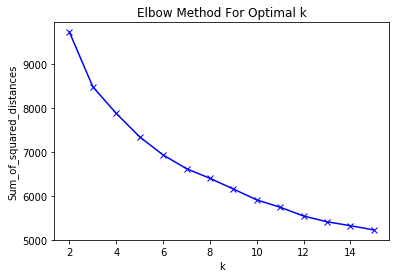

In [106]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

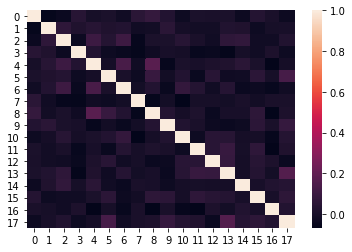

In [107]:
# Get The heatmap of corr to determine the clusters
sns.heatmap(np.corrcoef(raw_pos_data.iloc[:,2:-1],raw_neg_data.iloc[:,2:-1],rowvar=False))

In [86]:
if(mode == 2):
    if(subMode == 'a'):
        M = 9
else:
    M = 5
data = data.sample(frac=1)
train,test,val,mu = representativeClustering(data=data,sizeOfTheCluster=M,seed=421)
if(sampling == 'o'):
    pos = train[train['target'] == 1]
    neg = train[train['target'] == 0]
    train_pos = pd.concat([pos,pos,pos,pos,pos],ignore_index=True)
    train_neg = neg.sample(n=len(pos))
    train = pd.concat([train_pos,train_neg])
    del pos,neg,train_pos,train_neg
train = train.sample(frac=1,random_state=444).reset_index().iloc[:,1:]
train_lab = train.iloc[:,train.columns == 'target']
val_lab = val.iloc[:,val.columns == 'target']
test_lab = test.iloc[:,test.columns == 'target']
train = train.iloc[:,train.columns != 'target']
val = val.iloc[:,val.columns != 'target']
test = val.iloc[:,test.columns != 'target']
#print(data.head())

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_norm = pd.DataFrame(scaler.transform(train),columns=train.columns)
train_norm

,fm1,fm2,fm3,fm4,fm5,fm6,fm7,fm8,fm9
0,-1.225141,2.077330,1.527650,-1.203085,-0.664257,0.457790,0.085495,-1.306106,-0.667618
1,-1.225141,2.077330,-0.543601,1.309688,-0.664257,0.457790,0.085495,0.496648,-0.667618
2,-1.225141,1.304441,-0.543601,-1.203085,-0.664257,0.457790,-1.041079,-1.306106,1.497862
3,-0.063369,-0.241337,-0.543601,-0.365494,-0.664257,1.894774,-1.041079,-1.306106,-0.667618
4,-0.063369,0.531552,1.527650,0.472097,-0.664257,-0.979194,0.085495,1.398025,1.497862
5,1.098402,-1.014226,1.527650,0.472097,0.486818,0.457790,0.085495,1.398025,-0.667618
6,2.260174,0.531552,-0.543601,-1.203085,-0.664257,-0.979194,0.085495,-0.404729,-0.667618
7,-0.063369,-0.241337,-0.543601,1.309688,1.637894,0.457790,0.085495,-0.404729,-0.667618
8,1.098402,-1.014226,-0.543601,1.309688,-0.664257,0.457790,0.085495,-0.404729,-0.667618
9,-0.063369,-0.241337,-0.543601,-0.365494,1.637894,-0.979194,1.212069,1.398025,1.497862


In [95]:
covarMat = covar(train_norm,M)

In [96]:
#print(" Getting the covar over the training data based on number of basics we have implemented")
#covarMat = covar(train,M)
phiMat = genPhi(train,covarMat,M,mu)
valMat = genPhi(val,covarMat,M,mu)
testMat = genPhi(test,covarMat,M,mu)

In [90]:
np.random.seed(1994)
if(mode == 2):
    if(subMode == 'a'):
        prev_weight = np.zeros((M,1))
else:
    prev_weight = np.matrix(np.random.rand(M,1))
prev_weight

matrix([[0.3887621 ],
        [0.01547099],
        [0.94718274],
        [0.33959462],
        [0.78467214]])

In [17]:
def batchUpdateWeights(weights,phiMat,train_lab,alpha,lam): 
    midT = np.dot(phiMat,weights)
    deltaL = -(np.subtract(train_lab,midT))
    deltaD = np.dot(np.transpose(deltaL),phiMat)
    deltaE = np.transpose(deltaD) + np.dot(lam,prev_weight)

    delta = np.dot(-alpha,deltaE)
    new_weight = weights + delta
    return new_weight

In [19]:
batchUpdateWeights(prev_weight,phiMat,pd.DataFrame(train_lab),alpha,lam)

NameError: name 'alpha' is not defined

In [97]:
alpha = 0.001
lam = 0.005
if(mode == 2):
    if(subMode == 'a'):
        nprev_weight = np.zeros((M,1))
else:
    nprev_weight = np.matrix(np.random.rand(M,1))
    
while((np.subtract(prev_weight,prev_weight) == np.zeros((M,1))).all()):
    prev_weight = nprev_weight
    nprev_weight = batchUpdateWeights(prev_weight,phiMat,pd.DataFrame(train_lab),alpha,lam) 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


In [21]:
VAL_TEST_OUT  = GetValTest(valMat,prev_weight) 
GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))

('53.164556962025316,0.6031150545786021', 0.6031150545786021)

In [98]:
train_lab = np.asarray(train_lab)
log_erms_val = np.zeros(300000)
log_erms_train = np.zeros(300000)
log_erms_test = []
np.random.seed(589)
if(mode == 2):
    if(subMode == 'a'):
        prev_weight = np.zeros((M,1))
else:
    prev_weight = prev_weight = np.zeros((M,1))
'''1 B
alpha = 0.00003
lam = 0.5
sensitivity =  0.001
'''
alpha = 0.00003
lam = 0.5
sensitivity =  0.00000000001
pErms_Val = 0
nErms_Val = 10
ptrain_erms = 0
ntrain_erms = 10
epoch = 0
ValAccString = ''
TrainAccString = ''
'''
Logging for ERMS Train and Validate should have graphMode enabled
'''

graphMode = False

while(abs(ntrain_erms - ptrain_erms ) > sensitivity):
    print("Epoch: "+str(epoch))
    print(TrainAccString)
    print(ValAccString)
    for i in range(0,len(train)):
        #print("Iteration: "+str(i))
        prev_weight = updateWeights(prev_weight,phiMat[i],train_lab[i],alpha,lam)
        #-----------------TrainingData Accuracy---------------------#
        #TR_TEST_OUT   = GetValTest(phiMat,prev_weight) 
        #Erms_TR,train_erms       = GetErms(np.transpose(TR_TEST_OUT),np.asarray(train_lab))
        #print ('---------ValidationData Accuracy: ' + Erms_Val + '--------------')
        #VAL_TEST_OUT  = GetValTest(valMat,prev_weight) 
        #Erms_Val,val_erms      = GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))
        
        
        #---------------TestingData Accuracy---------------------#
        #TEST_OUT      = GetValTest(testMat,prev_weight) 
        #Erms_Test = GetErms(np.transpose(TEST_OUT),np.asarray(test_lab))
        #log_erms_test.append(float(Erms_Test.split(',')[1]))
        if(graphMode):
            log_erms_train[i] = train_erms
            log_erms_val[i] = val_erms
            
    #train,train_lab,phiMat = epoch_shuffle(train,train_lab,phiMat)
    
    TR_TEST_OUT   = GetValTest(phiMat,prev_weight)
    ptrain_erms = ntrain_erms
    TrainAccString,ntrain_erms       = GetErms(np.transpose(TR_TEST_OUT),np.asarray(train_lab))
    
    VAL_TEST_OUT  = GetValTest(valMat,prev_weight)
    pErms_Val = nErms_Val
    ValAccString,nErms_Val      = GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))
    epoch +=1
    #if(epoch >5):
       # pErms_Val = nErms_Val

Epoch: 0


Epoch: 1
49.9604743083004,0.6505932191811619
50.0,0.6503544573352176
Epoch: 2
49.9604743083004,0.608993404352446
50.0,0.6087903866909163
Epoch: 3
49.9604743083004,0.5788938527848272
50.0,0.5787216966492195
Epoch: 4
49.9604743083004,0.557312134193156
50.0,0.55716615732975
Epoch: 5
49.9604743083004,0.5419240617881126
50.0,0.5417999556813732
Epoch: 6
49.9604743083004,0.5309764041405202
50.0,0.5308703534428623
Epoch: 7
49.9604743083004,0.523181553377595
50.0,0.5230902825078267
Epoch: 8
49.9604743083004,0.5176128604617015
50.0,0.5175336209826948
Epoch: 9
49.9604743083004,0.5136128799254118
50.0,0.5135434020911692
Epoch: 10
49.9604743083004,0.510719384271971
50.0,0.5106578130333984
Epoch: 11
49.9604743083004,0.5086089831847397
50.0,0.5085538120188332
Epoch: 12
49.9604743083004,0.5070557679556504
50.0,0.5070057776932309
Epoch: 13
49.9604743083004,0.5059017437719936
50.0,0.5058559494065998
Epoch: 14
49.9604743083004,0.5050360433254983
50.0,0.5049936493868395
Epoch: 15
49.96047430830

Epoch: 120
49.9604743083004,0.5020302806558224
50.0,0.5020027785503319
Epoch: 121
49.9604743083004,0.5020302803028107
50.0,0.5020027786766783
Epoch: 122
49.9604743083004,0.5020302799564662
50.0,0.5020027788006742
Epoch: 123
49.9604743083004,0.502030279616657
50.0,0.5020027789223592
Epoch: 124
49.9604743083004,0.5020302792832569
50.0,0.5020027790417724
Epoch: 125
49.9604743083004,0.5020302789561418
50.0,0.502002779158953
Epoch: 126
49.9604743083004,0.5020302786351903
50.0,0.5020027792739402
Epoch: 127
49.9604743083004,0.5020302783202846
50.0,0.5020027793867726
Epoch: 128
49.9604743083004,0.5020302780113084
50.0,0.5020027794974895
Epoch: 129
49.9604743083004,0.5020302777081496
50.0,0.5020027796061292
Epoch: 130
49.9604743083004,0.5020302774106968
50.0,0.502002779712729
Epoch: 131
49.9604743083004,0.5020302771188421
50.0,0.5020027798173267
Epoch: 132
49.9604743083004,0.502030276832479
50.0,0.5020027799199591
Epoch: 133
49.9604743083004,0.5020302765515045
50.0,0.5020027800206623
Epoch: 134

Epoch: 236
49.9604743083004,0.502030263965941
50.0,0.5020027845287477
Epoch: 237
49.9604743083004,0.5020302639269252
50.0,0.5020027845427022
Epoch: 238
49.9604743083004,0.5020302638886442
50.0,0.5020027845563939
Epoch: 239
49.9604743083004,0.5020302638510826
50.0,0.5020027845698278
Epoch: 240
49.9604743083004,0.502030263814227
50.0,0.5020027845830091
Epoch: 241
49.9604743083004,0.5020302637780648
50.0,0.5020027845959417
Epoch: 242
49.9604743083004,0.5020302637425821
50.0,0.5020027846086311
Epoch: 243
49.9604743083004,0.5020302637077672
50.0,0.5020027846210816
Epoch: 244
49.9604743083004,0.5020302636736066
50.0,0.502002784633298
Epoch: 245
49.9604743083004,0.5020302636400884
50.0,0.502002784645284
Epoch: 246
49.9604743083004,0.5020302636072004
50.0,0.5020027846570444
Epoch: 247
49.9604743083004,0.5020302635749321
50.0,0.5020027846685837
Epoch: 248
49.9604743083004,0.5020302635432684
50.0,0.5020027846799056
Epoch: 249
49.9604743083004,0.5020302635122006
50.0,0.5020027846910141
Epoch: 250

In [ ]:
plotData(log_erms_train,log_erms_val,log_erms_test)

In [81]:
confusion_matrix(val_lab.iloc[:,0],np.array(np.round(VAL_TEST_OUT.reshape(np.shape(VAL_TEST_OUT)[1],1),0)))

array([[79,  0],
       [79,  0]])

In [92]:
conf_mat = confusion_matrix(val_lab.iloc[:,0],np.array(np.round(VAL_TEST_OUT.reshape(np.shape(VAL_TEST_OUT)[1],1),0)))
conf_mat

array([[79,  0],
       [79,  0]])

In [25]:
y_true = pd.Series(np.array(test_lab.iloc[:,0]))
y_pred = pd.Series(np.array((np.around(TR_TEST_OUT, 0))).ravel())

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,All
True,,
0,80,80
1,79,79
All,159,159
